In [145]:
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from IPython.display import display
import pymorphy3
from pymorphy3 import MorphAnalyzer
morph = MorphAnalyzer()
import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from wordcloud import WordCloud
from itertools import combinations
import statistics
from scipy import stats
from scipy.stats import chi2_contingency

In [2]:
import stanza
stanza.download('ru')
nlp_stanza = stanza.Pipeline(lang='ru', processors='tokenize, lemma, pos, depparse, ner')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-20 18:51:41 INFO: Downloaded file to /Users/sofiacherniakova/stanza_resources/resources.json
2026-02-20 18:51:41 INFO: Downloading default packages for language: ru (Russian) ...
2026-02-20 18:51:44 INFO: File exists: /Users/sofiacherniakova/stanza_resources/ru/default.zip
2026-02-20 18:51:52 INFO: Finished downloading models and saved to /Users/sofiacherniakova/stanza_resources
2026-02-20 18:51:52 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2026-02-20 18:51:53 INFO: Downloaded file to /Users/sofiacherniakova/stanza_resources/resources.json
2026-02-20

В этой тетраде метрики считаются отдельно по каждому сэмплу и потом усредняются для сравнения с корпусом лейблов.

In [ ]:
#Функция для предобработки публикаций
def clean(text):
    text = re.sub(r'(id|club)\d+', '', text) #удаляем внутренние ссылки вк
    text = re.sub(r'https?://\S+|vk\.com/\S+|soundcloud\.com/\S+|vk\.cc/\S+', '', text) #удаляем другие внешние ссылки
    text = re.sub(r'(?<=[,.])(?=\S)', ' ', text)
    text = re.sub(r'(?<!\w)-|-(?!\w)', '', text)
    text = re.sub(r'[^\w\s\d-]', '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.lower()
    text = text.strip()
    return text

stopwords_ru = stopwords.words('russian') + ['это', 'этот', 'такой', 'который', 'всё', 'ещё', 'the', 'её']

#Функция возвращает сразу три аргумента, которые могут понадобиться дальше - токены, леммы, леммы без стоп-слов
def lemmatize(text):
    tokens = word_tokenize(text)
    lemmas = [[morph.parse(token)[0].normal_form, morph.parse(token)[0].tag.POS] for token in tokens]
    lemmas_no_stop = [lemma for lemma in lemmas if lemma[0] not in stopwords_ru]
    return tokens, lemmas, lemmas_no_stop

In [4]:
posts_rz = []
for file in os.listdir('/Users/sofiacherniakova/Desktop/comp_lingu/project1/rz_samples'):
    df = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/rz_samples/' + file, sep=',')
    posts_rz.append(df)

Сравним TTR по сэмплам и в корпусе лейблов.

In [5]:
data_ttr_rz = []
for i in range(len(posts_rz)):
    posts_rz[i]['clean_text'] = posts_rz[i]['cut_text'].apply(clean)
    posts_rz[i][['tokens', 'lemmas', 'lemmas_no_stop']] = posts_rz[i]['clean_text'].apply(lambda x: pd.Series(lemmatize(x)))
    tokens_rz = posts_rz[i]['tokens'].explode().dropna().tolist()
    data_ttr_rz.append([len(tokens_rz), len(set(tokens_rz)), len(set(tokens_rz)) / len(tokens_rz)])

In [6]:
ttr_rz_df = pd.DataFrame(data_ttr_rz, columns=['Количество токенов', 'Из них уникальных', 'TTR'])
ttr_rz_df[''] = ['Сэмпл 1', 'Сэмпл 2', 'Сэмпл 3']
display(ttr_rz_df)
print(f'Средний TTR по сэмплам: {ttr_rz_df['TTR'].mean()}')

,Количество токенов,Из них уникальных,TTR,
0,25537,10110,0.395896,Сэмпл 1
1,25730,10172,0.395336,Сэмпл 2
2,25063,9930,0.396202,Сэмпл 3


Средний TTR по сэмплам: 0.39581130205507886


In [7]:
posts_labels = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/posts_labels.csv', sep=',')
posts_labels['clean_text'] = posts_labels['cut_text'].apply(clean)
posts_labels[['tokens', 'lemmas', 'lemmas_no_stop']] = posts_labels['clean_text'].apply(lambda x: pd.Series(lemmatize(x)))
tokens_labels = posts_labels['tokens'].explode().dropna().tolist()

In [8]:
data_ttr_labels = [len(tokens_labels), len(set(tokens_labels)), len(set(tokens_labels)) / len(tokens_labels)]
ttr_labels_df = pd.DataFrame([data_ttr_labels], columns=['Количество токенов', 'Из них уникальных', 'TTR'])
ttr_labels_df

,Количество токенов,Из них уникальных,TTR
0,24467,7727,0.315813


Сравним частеречную разметку для сэмплов Родного Звука и корпуса лейблов.

In [91]:
#Функция для вывода датафрема с частеречными тегами и их абсолютной и относительной частотностью
def pos_freq(dataframe):
    pos_list = [lemma[1] for lemma in dataframe['lemmas'].explode().dropna().tolist()]
    freq_pos = Counter(pos_list)
    df = pd.DataFrame(freq_pos.items()).rename(columns={0:'tag', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(pos_list))
    return df

#Функция для вывода столбчатой диаграммы с частеречными тегами и их абсолютной и относительной частотностью
def pos_bars(dataframe):
    dataframe.fillna('NONE', inplace=True)
    dataframe_top = dataframe.dropna().sort_values('rel_freq', ascending=False)
    plt.figure(figsize=(10, 5))
    plt.bar(dataframe_top['tag'][:10], dataframe_top['rel_freq'][:10])
    plt.xlabel('Части речи')
    plt.ylabel('Частотность')
    plt.title('Частотность частей речи')
    plt.xticks(rotation=45, ha='right') 
    plt.tight_layout()
    plt.show()

In [11]:
pos_freq_rz = []
for df in posts_rz:
    pos_freq_df = pos_freq(df)
    pos_freq_rz.append(pos_freq_df)

In [12]:
#Функция для вывода датафрейма со средней относительной частотностью тегов по списку датафреймов
def avg_rel_freq(df_list, group_col):
    combined = pd.concat([df[[group_col, 'rel_freq']] for df in df_list], ignore_index=True)   
    result = (combined.groupby(group_col, dropna=False, as_index=False)['rel_freq'].mean().sort_values('rel_freq', ascending=False))
    return result

In [13]:
pos_freq_rz_avg = avg_rel_freq(pos_freq_rz, 'tag')
pos_freq_rz_avg

,tag,rel_freq
8,NOUN,0.366115
0,ADJF,0.189246
13,PREP,0.123853
4,CONJ,0.076094
16,VERB,0.057829
17,NaN,0.048270
2,ADVB,0.036257
11,PRCL,0.024786
9,NPRO,0.024134
6,INFN,0.016154


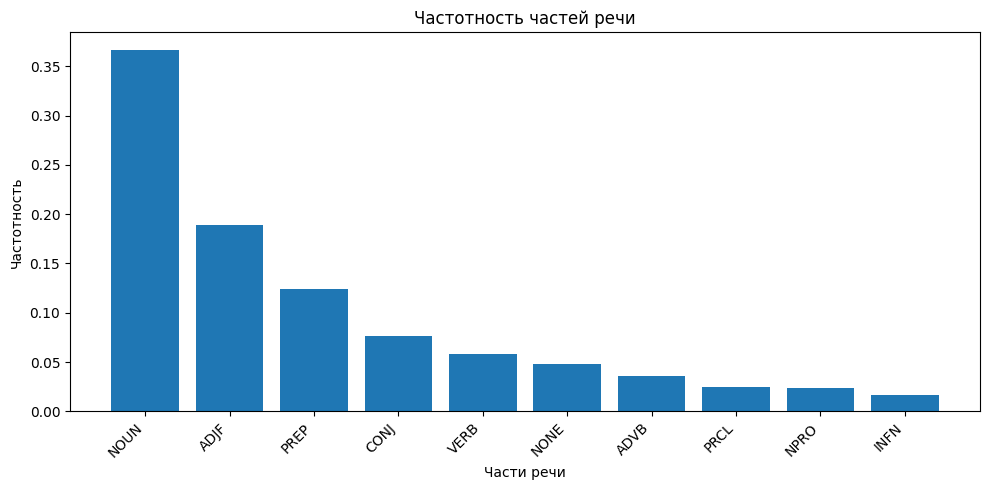

In [92]:
pos_bars(pos_freq_rz_avg)

In [15]:
pos_freq_labels = pos_freq(posts_labels)
pos_freq_labels.sort_values('rel_freq', ascending=False)

,tag,freq,rel_freq
1,NOUN,9149,0.373932
0,ADJF,4824,0.197164
2,PREP,3111,0.127151
4,CONJ,1799,0.073528
3,VERB,1499,0.061266
10,NaN,785,0.032084
9,ADVB,728,0.029754
6,PRCL,592,0.024196
11,NPRO,573,0.023419
8,INFN,484,0.019782


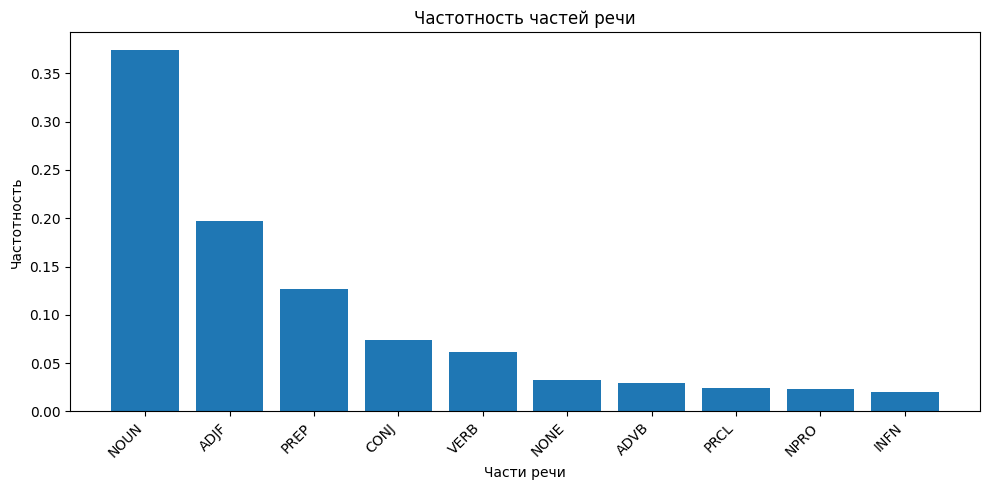

In [93]:
pos_bars(pos_freq_labels)

Рассчитаем TTR, исключив слова без частеречного тега, чтобы проверить, влияет ли эта категория на разницу в метрике.

In [17]:
data_ttr_rz_no_none = []
for i in range(len(posts_rz)):
    tokens_rz = [lemma[0] for lemma in posts_rz[i]['lemmas'].explode().dropna().tolist() if lemma[1] != None]
    data_ttr_rz_no_none.append([len(tokens_rz), len(set(tokens_rz)), len(set(tokens_rz)) / len(tokens_rz)])
ttr_rz_df_no_none = pd.DataFrame(data_ttr_rz_no_none, columns=['Количество токенов с частеречным тегом', 'Из них уникальных', 'TTR'])
ttr_rz_df_no_none[''] = ['Сэмпл 1', 'Сэмпл 2', 'Сэмпл 3']
display(ttr_rz_df_no_none)
print(f'Средний TTR по сэмплам: {ttr_rz_df_no_none['TTR'].mean()}')

,Количество токенов с частеречным тегом,Из них уникальных,TTR,
0,24355,5791,0.237775,Сэмпл 1
1,24392,5811,0.238234,Сэмпл 2
2,23897,5766,0.241286,Сэмпл 3


Средний TTR по сэмплам: 0.239097982815928


In [18]:
tokens_no_none_labels = [lemma[0] for lemma in posts_labels['lemmas'].explode().dropna().tolist() if lemma[1] != None]
data_ttr_labels_no_none = [len(tokens_no_none_labels), len(set(tokens_no_none_labels)), len(set(tokens_no_none_labels)) / len(tokens_no_none_labels)]
ttr_labels_df_no_none = pd.DataFrame([data_ttr_labels_no_none], columns=['Количество токенов с частеречным тегом', 'Из них уникальных', 'TTR'])
ttr_labels_df_no_none

,Количество токенов с частеречным тегом,Из них уникальных,TTR
0,23682,4135,0.174605


Проведем сравнительный анализ при помощи словаря эмотивной лексики: посчитаем ее долю, создадим облако слов из наиболее частотных токенов из словаря и выведем распределение токенов по эмоциональным классам.

In [19]:
#Функция для вывода датафрейма с леммами после очистки стоп-слов и их абсолютной и относительной частотностью
def lemma_all_freq(dataframe):
    lemmas_list = [lemma[0] for lemma in dataframe['lemmas_no_stop'].explode().dropna().tolist()]
    freq_lemmas = Counter(lemmas_list)
    df = pd.DataFrame(freq_lemmas.items()).rename(columns={0:'lemma', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(lemmas_list))
    return df

#Функция для генерации облака слов из датафрейма с леммами и их частотностью
def wordcloud_from_freq(dataframe):
    freq_dict = dict(zip(dataframe['lemma'], dataframe['rel_freq']))
    wordcloud = WordCloud(max_words=50, background_color='white', colormap = 'inferno_r', width=800, height=400, random_state=21, max_font_size=110).generate_from_frequencies(freq_dict)
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [20]:
emot_lex_df = pd.read_csv('/Users/sofiacherniakova/Desktop/comp_lingu/project1/emot_lex.csv', sep=',')
with open('/Users/sofiacherniakova/Desktop/comp_lingu/project1/emot_lex_list.txt', 'r', encoding='utf-8') as file:
    emot_lex_list = file.read().split()
print(f'Количество токенов в нашем словаре эмотивной лексики: {len(set(emot_lex_list))}')

#Функция для вывода эмотивной лексики среди лемм
def emot_lex_search(lemmas):
    emot_lex = [lemma for lemma in lemmas if lemma[0] in emot_lex_list]
    return emot_lex

emot_lex_df['Токены'] = emot_lex_df['Токены'].apply(lambda x: x.split())
emot_lex_dict = dict(zip(emot_lex_df['Класс'], emot_lex_df['Токены']))

#Функция для определения класса эмоции по словарю
def get_emot_class(lemma):
    return [k for k, v in emot_lex_dict.items() if lemma in v]

#Функция для вывода датафрейма с токеном из словаря эмотивной лексики, его абсолютной и относительной частотностью и классом/классами эмоций
def emot_lex_freq_class(dataframe):
    lemmas_list = [lemma[0] for lemma in dataframe['emot_lex_tokens'].explode().dropna().tolist()]
    freq_lemmas = Counter(lemmas_list)
    df = pd.DataFrame(freq_lemmas.items()).rename(columns={0:'lemma', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(lemmas_list))
    df['class'] = df['lemma'].apply(get_emot_class)
    return df

Количество токенов в нашем словаре эмотивной лексики: 4777


In [21]:
data_emot_lex_rz = []
for i in range(len(posts_rz)):
    posts_rz[i]['emot_lex_tokens'] = posts_rz[i]['lemmas_no_stop'].apply(emot_lex_search)
    emot_lex_tokens_rz = [lemma[0] for lemma in posts_rz[i]['emot_lex_tokens'].explode().dropna().tolist()]
    tokens_rz = posts_rz[i]['tokens'].explode().dropna().tolist()
    posts_rz[i]['emot_lex_count'] = posts_rz[i]['emot_lex_tokens'].apply(len)
    data_emot_lex_rz.append([len(emot_lex_tokens_rz), len(set(emot_lex_tokens_rz)), len(emot_lex_tokens_rz) / len(tokens_rz), posts_rz[i]['emot_lex_count'].mean()])

emot_lex_rz_df = pd.DataFrame(data_emot_lex_rz, columns=['Количество токенов из словаря', 'Из них уникальных', 'Доля в сэмпле', 'Среднее количество токенов из словаря на публикацию'])
emot_lex_rz_df[''] = ['Сэмпл 1', 'Сэмпл 2', 'Сэмпл 3']
display(emot_lex_rz_df)
print(f'Средняя доля эмотивной лексики в сэмплах: {emot_lex_rz_df['Доля в сэмпле'].mean()}')
print(f'Среднее количество эмотивной лексики на публикацию в сэмплах: {emot_lex_rz_df['Среднее количество токенов из словаря на публикацию'].mean()}')

,Количество токенов из словаря,Из них уникальных,Доля в сэмпле,Среднее количество токенов из словаря на публикацию,
0,1405,475,0.055018,1.277273,Сэмпл 1
1,1347,457,0.052351,1.224545,Сэмпл 2
2,1389,474,0.055420,1.262727,Сэмпл 3


Средняя доля эмотивной лексики в сэмплах: 0.05426329682066374
Среднее количество эмотивной лексики на публикацию в сэмплах: 1.2548484848484849


In [22]:
posts_labels['emot_lex_tokens'] = posts_labels['lemmas_no_stop'].apply(emot_lex_search)
emot_lex_tokens_labels = [lemma[0] for lemma in posts_labels['emot_lex_tokens'].explode().dropna().tolist()]
posts_labels['emot_lex_count'] = posts_labels['emot_lex_tokens'].apply(len)

data_emot_lex_labels = [len(emot_lex_tokens_labels), len(set(emot_lex_tokens_labels)), len(emot_lex_tokens_labels) / len(tokens_labels), posts_labels['emot_lex_count'].mean()]
emot_lex_labels_df = pd.DataFrame([data_emot_lex_labels], columns=['Количество токенов из словаря', 'Из них уникальных', 'Доля в сэмпле', 'Среднее количество токенов из словаря на публикацию'])
emot_lex_labels_df

,Количество токенов из словаря,Из них уникальных,Доля в сэмпле,Среднее количество токенов из словаря на публикацию
0,1865,399,0.076225,2.007535


In [23]:
emot_lex_freq_rz = []
emot_lex_classes_rz = []
for df in posts_rz:
    emot_lex_freq = emot_lex_freq_class(df)
    emot_lex_freq['class_str'] = emot_lex_freq['class'].apply(lambda x: ', '.join(x))
    emot_lex_freq_rz.append(emot_lex_freq)
    emot_lex_classes = (emot_lex_freq.groupby('class_str')['rel_freq'].sum().reset_index())
    emot_lex_classes_rz.append(emot_lex_classes)

In [24]:
emot_lex_freq_rz_avg = avg_rel_freq(emot_lex_freq_rz, 'lemma')
emot_lex_freq_rz_avg.head(20)

,lemma,rel_freq
223,любовь,0.045955
754,хороший,0.028438
245,мрачный,0.019339
276,настроение,0.016164
774,чувство,0.014999
470,приятный,0.014038
85,герой,0.013055
256,надежда,0.013047
44,вдохновить,0.013028
288,нежный,0.012787


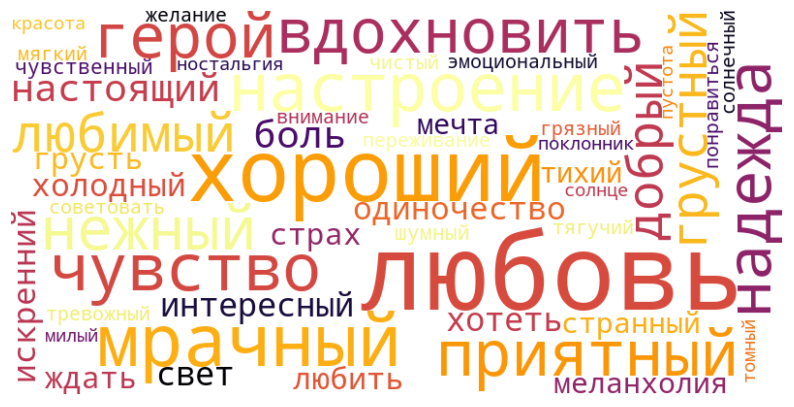

In [25]:
wordcloud_from_freq(emot_lex_freq_rz_avg)

In [26]:
emot_lex_classes_rz_avg = avg_rel_freq(emot_lex_classes_rz, 'class_str')
emot_lex_classes_rz_avg.head(20)

,class_str,rel_freq
32,ГРУСТЬ,0.093470
56,ЛЮБОВЬ,0.082092
19,"ВЛЕЧЕНИЕ, ЛЮБОВЬ",0.068966
80,РАДОСТЬ,0.065403
24,ГОРЕ,0.061598
0,БЕСПОКОЙСТВО,0.043012
54,ИСКРЕННОСТЬ,0.042811
36,ДОБРОТА,0.042012
47,ЖЕЛАНИЕ,0.036268
40,"ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ",0.028438


In [99]:
emot_lex_freq_labels = emot_lex_freq_class(posts_labels)
display(emot_lex_freq_labels.sort_values(by='rel_freq', ascending=False).head(20))
emot_lex_freq_labels['class_str'] = emot_lex_freq_labels['class'].apply(lambda x: ', '.join(x))
emot_lex_classes_labels = (emot_lex_freq_labels.groupby('class_str')['rel_freq'].sum().reset_index())
display(emot_lex_classes_labels.sort_values('rel_freq', ascending=False).head(20))

,lemma,freq,rel_freq,class
9,любовь,212,0.113673,"[ВЛЕЧЕНИЕ, ЛЮБОВЬ]"
6,чувство,97,0.052011,"[ВЛЕЧЕНИЕ, ЛЮБОВЬ]"
58,герой,72,0.038606,[ОДОБРЕНИЕ]
25,эмоциональный,36,0.019303,[БЕСПОКОЙСТВО]
98,вдохновить,35,0.018767,[ВДОХНОВЕНИЕ]
36,искренний,32,0.017158,[ИСКРЕННОСТЬ]
45,хороший,27,0.014477,"[ДОБРОТА, ЛЮБОВЬ, ОДОБРЕНИЕ]"
72,ностальгия,27,0.014477,[ГРУСТЬ]
100,переживание,25,0.013405,[ГОРЕ]
82,желание,23,0.012332,"[ВЛЕЧЕНИЕ, ЖЕЛАНИЕ]"


,class_str,rel_freq
13,"ВЛЕЧЕНИЕ, ЛЮБОВЬ",0.174263
17,ГОРЕ,0.077212
42,ЛЮБОВЬ,0.063271
21,ГРУСТЬ,0.059517
60,РАДОСТЬ,0.051475
0,БЕСПОКОЙСТВО,0.047721
40,ИСКРЕННОСТЬ,0.046113
54,ОДОБРЕНИЕ,0.042895
34,ЖЕЛАНИЕ,0.030027
50,НЕПРИЯЗНЬ,0.029491


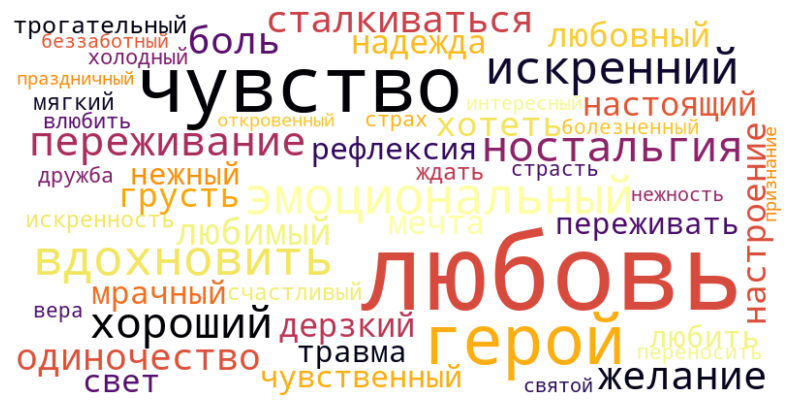

In [28]:
wordcloud_from_freq(emot_lex_freq_labels)

Для синтактического анализа и анализа именных сущностей воспользуемся Stanza.

In [29]:
#Функция для предобработки публикаций для анализа stanza
def clean_for_stanza(text):
    text = re.sub(r'(id|club)\d+', '', text) #удаляем внутренние ссылки вк
    text = re.sub(r'https?://\S+|vk\.com/\S+|soundcloud\.com/\S+|vk\.cc/\S+', '', text) #удаляем другие внешние ссылки
    text = re.sub(r'(?<=[,.])(?=\S)', ' ', text)
    #text = re.sub(r'(?<!\w)-|-(?!\w)', ' ', text)
    text = re.sub(r'[^,\.!?:;\w\s\d-]', '', text)
    text = re.sub(r'(?<![.!?])\s*\n', '.\n', text)
    text = re.sub(r'\n{2,}', '\n', text)
    text = re.sub(r'\s{2,}', ' ', text)
    text = text.strip()
    return text

#Функция, которая проведет разбор текста при помощи stanza и вернет три аргумента: морфологический/синтаксический анализ каждого предложения (для каждого токена - изначальный текст, лемма, часть реч, индекс управляющего слова, тип синтаксической связи), 
#список NER и количество предложений
def stanza_analysis(text):
    doc = nlp_stanza(text)
    data_morphosyntax = []    
    for sentence in doc.sentences:
        sent_analysis = []
        for token in sentence.tokens:
            if token.words:
                w = token.words[0]
                sent_analysis.append([w.text, w.lemma, w.upos, w.head, w.deprel])
        data_morphosyntax.append(sent_analysis)
    data_ents = [[ent.text, ent.type] for ent in doc.ents]
    return data_morphosyntax, data_ents, len(doc.sentences)

#Функция для получения зависимых групп предложения (вернет список, где каждый элемент - это кортеж из управляющего слова и слов, зависимых от него)
def dep_groups_for_sent(sentence):
    deps = {} #соберем словарь c индексами управляющих слов в качестве ключей и индексами слов, которые от него зависят, в качестве значений
    for i in range(len(sentence)):
        token = sentence[i]
        text, lemma, pos, head, deprel = token
        if head not in deps:
            deps[head] = []
        deps[head].append(i)
    groups = []
    #для каждого токена собирем список его зависимых
    for i in range(len(sentence)):
        token = sentence[i]
        dependent_indices = deps.get(i + 1, [])
        dependents = []
        for dep_i in dependent_indices:
            dependent_token = sentence[dep_i]
            dependents.append(dependent_token)
        #оставляем только узлы, у которых есть зависимые
        if len(dependents) > 0:
            groups.append((token, dependents))
    return groups

#Функция для получения зависимых групп текста (вернет список из списков результатов предыдущей функции по предложениям)
def dep_groups_for_text(text):
    return [dep_groups_for_sent(sent) for sent in text]

#Функция для подсчета среднего количества зависимых групп на предложения
def avg_groups_per_sent(groups_by_text):
    total_groups = sum(len(sent_groups) for sent_groups in groups_by_text)
    num_sent = len(groups_by_text)
    return total_groups / num_sent if num_sent > 0 else 0

#Функция для подсчета среднего количества зависимых слов на управляющее
def avg_dep_per_head(groups_by_text):
    total_deps = 0
    total_heads = 0
    for sent_groups in groups_by_text:
        for head, deps in sent_groups:
            total_deps += len(deps)
            total_heads += 1
    return total_deps / total_heads if total_heads > 0 else 0

In [30]:
posts_labels['clean_for_stanza'] = posts_labels['cut_text'].apply(clean_for_stanza)
posts_labels[['data_morphosyntax', 'data_ents', 'sent_num']] = posts_labels['clean_for_stanza'].apply(lambda x: pd.Series(stanza_analysis(x)))
posts_labels['dep_groups'] = posts_labels['data_morphosyntax'].apply(dep_groups_for_text)
posts_labels['avg_groups_per_sent'] = posts_labels['dep_groups'].apply(avg_groups_per_sent)
posts_labels['avg_dep_per_head'] = posts_labels['dep_groups'].apply(avg_dep_per_head)
posts_labels.head()

,Unnamed: 0,id,group_id,date,text,cut_text,clean_text,tokens,lemmas,lemmas_no_stop,emot_lex_tokens,emot_lex_count,clean_for_stanza,data_morphosyntax,data_ents,sent_num,dep_groups,avg_groups_per_sent,avg_dep_per_head
0,0,24202,16325867,2026-01-23 04:09:12,[https://vk.com/elvirat_official|Elvira T] – П...,"Дерзкий поп-трек, в котором женская сила подаё...",дерзкий поп-трек в котором женская сила подаёт...,"[дерзкий, поп-трек, в, котором, женская, сила,...","[[дерзкий, ADJF], [поп-трек, NOUN], [в, PREP],...","[[дерзкий, ADJF], [поп-трек, NOUN], [женский, ...","[[дерзкий, ADJF], [подаваться, VERB]]",2,"Дерзкий поп-трек, в котором женская сила подаё...","[[[Дерзкий, дерзкий, ADJ, 2, amod], [поп-трек,...","[[Дерзкий поп-трек, MISC]]",1,"[[(['поп-трек', 'поп-трек', 'NOUN', 0, 'root']...",6.0,2.000000
1,1,24201,16325867,2026-01-23 04:09:01,[https://vk.com/public174256877|Арсен Шахунц] ...,"Лёгкий, тёплый и жизнерадостный трек Арсен Шах...",лёгкий тёплый и жизнерадостный трек арсен шаху...,"[лёгкий, тёплый, и, жизнерадостный, трек, арсе...","[[лёгкий, ADJF], [тёплый, ADJF], [и, CONJ], [ж...","[[лёгкий, ADJF], [тёплый, ADJF], [жизнерадостн...","[[жизнерадостный, ADJF]]",1,"Лёгкий, тёплый и жизнерадостный трек Арсен Шах...","[[[Лёгкий, лёгкий, ADJ, 6, amod], [,, ,, PUNCT...","[[Арсен Шахунц, PER]]",1,"[[(['Лёгкий', 'лёгкий', 'ADJ', 6, 'amod'], [['...",10.0,2.000000
2,2,24200,16325867,2026-01-23 04:08:51,[https://vk.com/bezobid_music|без обид] – прот...,"Это агрессивная альтернатива, смешивающая каче...",это агрессивная альтернатива смешивающая качев...,"[это, агрессивная, альтернатива, смешивающая, ...","[[это, PRCL], [агрессивный, ADJF], [альтернати...","[[агрессивный, ADJF], [альтернатива, NOUN], [с...","[[смешивать, PRTF], [злой, ADJF], [ненависть, ...",3,"Это агрессивная альтернатива, смешивающая каче...","[[[Это, это, PRON, 3, nsubj], [агрессивная, аг...",[],1,"[[(['альтернатива', 'альтернатива', 'NOUN', 0,...",13.0,2.692308
3,3,24199,16325867,2026-01-23 04:08:37,[https://vk.com/volodinakristina|моя волна] - ...,"Новый трек о чувствах, которые потерпели пораж...",новый трек о чувствах которые потерпели пораже...,"[новый, трек, о, чувствах, которые, потерпели,...","[[новый, ADJF], [трек, NOUN], [о, PREP], [чувс...","[[новый, ADJF], [трек, NOUN], [чувство, NOUN],...","[[чувство, NOUN], [потерпеть, VERB]]",2,"Новый трек о чувствах, которые потерпели пораж...","[[[Новый, новый, ADJ, 2, amod], [трек, трек, N...",[],1,"[[(['трек', 'трек', 'NOUN', 0, 'root'], [['Нов...",6.0,2.000000
4,4,24173,16325867,2026-01-16 04:03:38,[https://vk.com/officialsvyat|Свят] - Банально...,Мечтательный инди-поп с саундтрековым звучанием.,мечтательный инди-поп с саундтрековым звучанием,"[мечтательный, инди-поп, с, саундтрековым, зву...","[[мечтательный, ADJF], [инди-поп, NOUN], [с, P...","[[мечтательный, ADJF], [инди-поп, NOUN], [саун...",[],0,Мечтательный инди-поп с саундтрековым звучанием.,"[[[Мечтательный, мечтательный, ADJ, 2, amod], ...","[[Мечтательный, MISC]]",1,"[[(['инди-поп', 'инди-поп', 'NOUN', 0, 'root']...",2.0,2.500000


Для сравнения синтаксиса расчитаем среднее количество зависимых групп на предложение и среднее количество зависимых слов.

In [31]:
synt_list_labels = [posts_labels['avg_groups_per_sent'].mean(), posts_labels['avg_groups_per_sent'].std(), posts_labels['avg_groups_per_sent'].std() / posts_labels['avg_groups_per_sent'].mean(), posts_labels['avg_groups_per_sent'].median(), posts_labels['avg_dep_per_head'].mean(), posts_labels['avg_dep_per_head'].std(), posts_labels['avg_dep_per_head'].std() / posts_labels['avg_dep_per_head'].mean(), posts_labels['avg_dep_per_head'].median()]
synt_str_labels = ['Среднее количество зависимых групп на предложение', '(Стандартое отклонение)', '(Коэффициент вариации)', '(Медианное значение)', 'Среднее количество зависимых слов на управляющее слово', '(Стандартое отклонение)', '(Коэффициент вариации)', '(Медианное значение)']
syntax_labels = pd.DataFrame(list(zip(synt_str_labels, synt_list_labels))).rename(columns={0: '', 1: 'Корпус лейблов'})
syntax_labels

,,Корпус лейблов
0,Среднее количество зависимых групп на предложение,5.510239
1,(Стандартое отклонение),2.632801
2,(Коэффициент вариации),0.477802
3,(Медианное значение),5.000000
4,Среднее количество зависимых слов на управляющ...,2.229281
5,(Стандартое отклонение),0.434264
6,(Коэффициент вариации),0.194800
7,(Медианное значение),2.222222


In [32]:
for i in range(len(posts_rz)):
    posts_rz[i]['clean_for_stanza'] = posts_rz[i]['cut_text'].apply(clean_for_stanza)
    posts_rz[i][['data_morphosyntax', 'data_ents', 'sent_num']] = posts_rz[i]['clean_for_stanza'].apply(lambda x: pd.Series(stanza_analysis(x)))
    posts_rz[i]['dep_groups'] = posts_rz[i]['data_morphosyntax'].apply(dep_groups_for_text)
    posts_rz[i]['avg_groups_per_sent'] = posts_rz[i]['dep_groups'].apply(avg_groups_per_sent)
    posts_rz[i]['avg_dep_per_head'] = posts_rz[i]['dep_groups'].apply(avg_dep_per_head)

In [33]:
data_syntax_rz = []
for i in range(len(posts_rz)):
    avg_group_per_sent = posts_rz[i]['avg_groups_per_sent'].mean()
    avg_group_per_sent_std = posts_rz[i]['avg_groups_per_sent'].std()
    avg_group_per_sent_cv = avg_group_per_sent_std / avg_group_per_sent
    avg_group_per_sent_med = posts_rz[i]['avg_groups_per_sent'].median()
    avg_dep_per_head = posts_rz[i]['avg_dep_per_head'].mean()
    avg_dep_per_head_std = posts_rz[i]['avg_dep_per_head'].std()
    avg_dep_per_head_cv = avg_dep_per_head_std / avg_dep_per_head
    avg_dep_per_head_med = posts_rz[i]['avg_dep_per_head'].median()
    data_syntax_rz.append([avg_group_per_sent, avg_group_per_sent_std, avg_group_per_sent_cv, avg_group_per_sent_med, avg_dep_per_head, avg_dep_per_head_std, avg_dep_per_head_cv,  avg_dep_per_head_med])


In [34]:
df = pd.DataFrame(data_syntax_rz, columns=['Среднее количество зависимых групп на предложение', '(Стандартое отклонение)', '(Коэффициент вариации)', '(Медианное значение)', 'Среднее количество зависимых слов на управляющее слово', '(Стандартое отклонение)', '(Коэффициент вариации)', '(Медианное значение)'])
syntax_rz = df.transpose().rename(columns={0: 'Сэмпл 1', 1: 'Сэмпл 2', 2: 'Сэмпл 3'})
syntax_rz

,Сэмпл 1,Сэмпл 2,Сэмпл 3
Среднее количество зависимых групп на предложение,5.051388,5.195459,5.077681
(Стандартое отклонение),2.764140,2.885229,2.724820
(Коэффициент вариации),0.547204,0.555337,0.536627
(Медианное значение),4.600000,4.845238,4.612500
Среднее количество зависимых слов на управляющее слово,2.276342,2.266516,2.265488
(Стандартое отклонение),0.454389,0.432598,0.488454
(Коэффициент вариации),0.199614,0.190865,0.215606
(Медианное значение),2.250000,2.250000,2.238095


Также оценим распределение типов синтактических связей в корпусе лейблов и сэмплах.

In [35]:
deprel_list_labels = [lemma[4] for lemma in posts_labels['data_morphosyntax'].explode().explode().dropna().tolist()]
deprel_count_labels = Counter(deprel_list_labels)
deprel_df_labels = pd.DataFrame(deprel_count_labels.items()).rename(columns={0:'tag', 1:'freq'})
deprel_df_labels['rel_freq'] = deprel_df_labels['freq'].apply(lambda x: x / len(deprel_list_labels))
deprel_df_labels = deprel_df_labels[['tag', 'rel_freq']]
deprel_df_labels.sort_values('rel_freq', ascending=False).head(20)

,tag,rel_freq
2,punct,0.155629
0,amod,0.124880
9,nmod,0.112827
3,case,0.105705
1,root,0.075914
4,obl,0.063484
10,conj,0.062526
15,nsubj,0.057869
11,cc,0.045884
17,advmod,0.031160


In [36]:
deprel_df_rz = []
for i in range(len(posts_rz)):
    deprel_list_rz = [lemma[4] for lemma in posts_rz[i]['data_morphosyntax'].explode().explode().dropna().tolist()]
    deprel_count_rz = Counter(deprel_list_rz)
    deprel_df = pd.DataFrame(deprel_count_rz.items()).rename(columns={0:'tag', 1:'freq'})
    deprel_df['rel_freq'] = deprel_df['freq'].apply(lambda x: x / len(deprel_list_labels))
    deprel_df_rz.append(deprel_df)

In [37]:
deprel_df_rz_avg = avg_rel_freq(deprel_df_rz, 'tag')
deprel_df_rz_avg.head(20)

,tag,rel_freq
37,punct,0.172591
4,amod,0.128487
25,nmod,0.113375
8,case,0.106641
38,root,0.081188
12,conj,0.066989
32,obl,0.058907
26,nsubj,0.054707
9,cc,0.047265
3,advmod,0.036536


In [ ]:
#с подсчетом разницы и ранжированием помогал chat-gpt
deprel_diff_df = (deprel_df_labels[['tag', 'rel_freq']].rename(columns={'rel_freq': 'rel_freq_l'}).merge(deprel_df_rz_avg[['tag', 'rel_freq']].rename(columns={'rel_freq': 'rel_freq_rz'}), on='tag', how='outer'))
deprel_diff_df = deprel_diff_df.fillna(0)
deprel_diff_df['abs_diff'] = deprel_diff_df['rel_freq_l'] - deprel_diff_df['rel_freq_rz']
epsilon = 1e-9
deprel_diff_df['ratio'] = (deprel_diff_df['rel_freq_l'] + epsilon) / (deprel_diff_df['rel_freq_rz'] + epsilon)
deprel_diff_df['log_ratio'] = np.log(deprel_diff_df['ratio'])
deprel_diff_df['abs_z'] = (deprel_diff_df['abs_diff'] - deprel_diff_df['abs_diff'].mean()) / deprel_diff_df['abs_diff'].std(ddof=0)
deprel_diff_df['log_ratio_z'] = (deprel_diff_df['log_ratio'] - deprel_diff_df['log_ratio'].mean()) / deprel_diff_df['log_ratio'].std(ddof=0)
deprel_diff_df['combined_score'] = deprel_diff_df['abs_z'] + deprel_diff_df['log_ratio_z']

Посчитаем разницу долей и выведем топ с наибольшей разницей в сторону сэмплов и в сторону корпуса лейблов.

In [147]:
deprel_diff_df.sort_values(by='combined_score').head(5)

,tag,rel_freq_l,rel_freq_rz,abs_diff,ratio,log_ratio,abs_z,log_ratio_z,combined_score
33,obl:agent,0.000000,0.000034,-0.000034,0.000029,-10.441234,0.331391,-4.324900,-3.993509
15,csubj:pass,0.000000,0.000034,-0.000034,0.000029,-10.441234,0.331391,-4.324900,-3.993509
37,punct,0.155629,0.172591,-0.016961,0.901726,-0.103444,-3.919576,0.281469,-3.638108
21,flat:foreign,0.019107,0.031274,-0.012167,0.610949,-0.492742,-2.715661,0.108003,-2.607658
5,appos,0.006027,0.013206,-0.007179,0.456353,-0.784489,-1.463016,-0.021995,-1.485011


In [148]:
deprel_diff_df.sort_values(by='combined_score', ascending=False).head(5)

,tag,rel_freq_l,rel_freq_rz,abs_diff,ratio,log_ratio,abs_z,log_ratio_z,combined_score
1,acl:relcl,0.013834,0.008583,0.005250,1.611702,0.477291,1.658565,0.540236,2.198800
32,obl,0.063484,0.058907,0.004577,1.077698,0.074827,1.489443,0.360904,1.850347
31,obj,0.029517,0.026172,0.003344,1.127780,0.120251,1.179865,0.381144,1.561009
26,nsubj,0.057869,0.054707,0.003162,1.057793,0.056184,1.134001,0.352597,1.486598
40,xcomp,0.007191,0.005376,0.001815,1.337580,0.290862,0.795759,0.457166,1.252924


Выведем примеры разборов из Stanza, в которых есть типы связей из датафреймов в предыдущем шаге.

In [59]:
acl_relcl_labels = posts_labels[posts_labels['data_morphosyntax'].apply(lambda text: any('acl:relcl' in word for sentence in text for word in sentence))]
acl_relcl_labels['data_morphosyntax'].tolist()[0]

[[['Дерзкий', 'дерзкий', 'ADJ', 2, 'amod'],
  ['поп-трек', 'поп-трек', 'NOUN', 0, 'root'],
  [',', ',', 'PUNCT', 8, 'punct'],
  ['в', 'в', 'ADP', 5, 'case'],
  ['котором', 'который', 'PRON', 8, 'obl'],
  ['женская', 'женский', 'ADJ', 7, 'amod'],
  ['сила', 'сила', 'NOUN', 8, 'nsubj:pass'],
  ['подаётся', 'подавать', 'VERB', 2, 'acl:relcl'],
  ['как', 'как', 'SCONJ', 10, 'mark'],
  ['искусство', 'искусство', 'NOUN', 8, 'advcl'],
  ['тонкой', 'тонкий', 'ADJ', 12, 'amod'],
  ['магии', 'магия', 'NOUN', 10, 'nmod'],
  ['.', '.', 'PUNCT', 2, 'punct']]]

In [150]:
det_labels = posts_labels[posts_labels['data_morphosyntax'].apply(lambda text: any('xcomp' in word for sentence in text for word in sentence))]
det_labels['data_morphosyntax'].tolist()[1]

[[['На', 'на', 'ADP', 3, 'case'],
  ['сей', 'сей', 'DET', 3, 'det'],
  ['раз', 'раз', 'NOUN', 5, 'obl'],
  ['группа', 'группа', 'NOUN', 5, 'nsubj'],
  ['решила', 'решить', 'VERB', 0, 'root'],
  ['поиграться', 'поиграться', 'VERB', 5, 'xcomp'],
  ['с', 'с', 'ADP', 8, 'case'],
  ['красками', 'краска', 'NOUN', 6, 'obl'],
  ['и', 'и', 'CCONJ', 10, 'cc'],
  ['отойти', 'отойти', 'VERB', 6, 'conj'],
  ['от', 'от', 'ADP', 13, 'case'],
  ['привычной', 'привычный', 'ADJ', 13, 'amod'],
  ['меланхолии', 'меланхолия', 'NOUN', 10, 'obl'],
  ['к', 'к', 'ADP', 17, 'case'],
  ['огненному', 'огнеть', 'VERB', 17, 'amod'],
  ['мотивационному', 'мотивационный', 'ADJ', 17, 'amod'],
  ['драйву', 'драйва', 'NOUN', 10, 'obl'],
  ['чтобы', 'чтобы', 'SCONJ', 19, 'mark'],
  ['передать', 'передать', 'VERB', 10, 'advcl'],
  ['слушателю', 'слушатель', 'NOUN', 19, 'iobj'],
  ['истинный', 'истинный', 'ADJ', 22, 'amod'],
  ['вайб', 'вайб', 'NOUN', 19, 'obj'],
  ['свободы', 'свобода', 'NOUN', 22, 'nmod'],
  ['и', 'и', '

In [74]:
appos_rz = posts_rz[0][posts_rz[0]['data_morphosyntax'].apply(lambda text: any('appos' in word for sentence in text for word in sentence))]
appos_rz['data_morphosyntax'].tolist()[1]

[[['Мария', 'Мария', 'PROPN', 14, 'nsubj'],
  ['Теряева', 'Теряев', 'PROPN', 1, 'flat:name'],
  [',', ',', 'PUNCT', 6, 'punct'],
  ['в', 'в', 'ADP', 5, 'case'],
  ['прошлом', 'прошлое', 'NOUN', 6, 'obl'],
  ['известная', 'известный', 'ADJ', 1, 'acl'],
  ['по', 'по', 'ADP', 8, 'case'],
  ['проекту', 'проект', 'NOUN', 6, 'obl'],
  ['Дуб', 'Дуб', 'PROPN', 8, 'appos'],
  ['и', 'и', 'CCONJ', 12, 'cc'],
  ['просто', 'просто', 'PART', 12, 'advmod'],
  ['дерево', 'дерево', 'NOUN', 9, 'conj'],
  [',', ',', 'PUNCT', 6, 'punct'],
  ['записала', 'записать', 'VERB', 0, 'root'],
  ['свой', 'свой', 'DET', 17, 'det'],
  ['дебютный', 'дебютный', 'ADJ', 17, 'amod'],
  ['альбом', 'альбом', 'NOUN', 14, 'obj'],
  ['.', '.', 'PUNCT', 14, 'punct']],
 [['Вместо', 'вместо', 'ADP', 2, 'case'],
  ['гитары', 'гитара', 'NOUN', 0, 'root'],
  ['и', 'и', 'CCONJ', 4, 'cc'],
  ['пост-панка', 'пост-панка', 'NOUN', 2, 'conj'],
  ['здесь', 'здесь', 'ADV', 2, 'advmod'],
  ['модульные', 'модульный', 'ADJ', 7, 'amod'],
  ['с

Выведем распределение частей речи среди токенов-root - вершин древ зависимостей.

In [80]:
root_pos_labels = [lemma[2] for lemma in posts_labels['data_morphosyntax'].explode().explode().dropna().tolist()]
root_pos_count_labels = Counter(root_pos_labels)
root_pos_freq_labels = pd.DataFrame(root_pos_count_labels.items()).rename(columns={0:'tag', 1:'freq'})
root_pos_freq_labels['rel_freq'] = root_pos_freq_labels['freq'].apply(lambda x: x / len(root_pos_labels))
root_pos_freq_labels = root_pos_freq_labels[['tag', 'rel_freq']]
root_pos_freq_labels.sort_values('rel_freq', ascending=False)

,tag,rel_freq
1,NOUN,0.298178
2,PUNCT,0.156211
0,ADJ,0.137378
3,ADP,0.105636
5,VERB,0.089611
7,CCONJ,0.045507
8,PROPN,0.042118
4,PRON,0.040440
9,ADV,0.027565
11,DET,0.022531


In [81]:
root_pos_freq_rz = []
for i in range(len(posts_rz)):
    root_pos = [lemma[2] for lemma in posts_rz[i]['data_morphosyntax'].explode().explode().dropna().tolist()]
    root_pos_count = Counter(root_pos)
    df = pd.DataFrame(root_pos_count.items()).rename(columns={0:'tag', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(root_pos))
    root_pos_freq_rz.append(df)

In [83]:
root_pos_freq_rz_avg = avg_rel_freq(root_pos_freq_rz, 'tag')
root_pos_freq_rz_avg

,tag,rel_freq
7,NOUN,0.265848
12,PUNCT,0.163884
0,ADJ,0.138574
1,ADP,0.101422
15,VERB,0.078679
11,PROPN,0.077892
4,CCONJ,0.044512
10,PRON,0.035334
2,ADV,0.032443
5,DET,0.019667


Проведем сравнительный анализ извлеченных именованных сущностей: выведем распределение категорий сущностей и самые частотные токены.

In [121]:
ner_tag_freq_rz = []
for i in range(len(posts_rz)):
    ner_list = posts_rz[i]['data_ents'].explode().tolist()
    ner_tags = [ner[1] for ner in ner_list if isinstance(ner, list) and len(ner) > 1]
    print(f'Количество именованных сущностей в сэмпле {i+1}: {len(ner_tags)}')
    ner_tag_count = Counter(ner_tags)
    df = pd.DataFrame(ner_tag_count.items()).rename(columns={0:'tag', 1:'freq'})
    df['rel_freq'] = df['freq'].apply(lambda x: x / len(ner_tags))
    ner_tag_freq_rz.append(df)

Количество именованных сущностей в сэмпле 1: 2167
Количество именованных сущностей в сэмпле 2: 2170
Количество именованных сущностей в сэмпле 3: 2071


In [85]:
ner_tag_freq_rz_avg = avg_rel_freq(ner_tag_freq_rz, 'tag')
ner_tag_freq_rz_avg

,tag,rel_freq
1,MISC,0.307268
3,PER,0.304870
2,ORG,0.213383
0,LOC,0.174479


In [122]:
ner_list_labels = posts_labels['data_ents'].explode().tolist()
ner_tags_labels = [ner[1] for ner in ner_list_labels if isinstance(ner, list) and len(ner) > 1]
print(f'Количество именованных сущностей в корпусе лейблов: {len(ner_tags_labels)}')
ner_tag_count_labels = Counter(ner_tags_labels)
ner_tag_freq_labels = pd.DataFrame(ner_tag_count_labels.items()).rename(columns={0:'tag', 1:'freq'})
ner_tag_freq_labels['rel_freq'] = ner_tag_freq_labels['freq'].apply(lambda x: x / len(ner_tags_labels))
ner_tag_freq_labels = ner_tag_freq_labels[['tag', 'rel_freq']]

Количество именованных сущностей в корпусе лейблов: 1323


In [88]:
ner_tag_freq_labels.sort_values('rel_freq', ascending=False)

,tag,rel_freq
0,MISC,0.470899
1,PER,0.322751
2,ORG,0.163265
3,LOC,0.043084


In [47]:
ner_items_list_l = [ner[0] for ner in ner_list_labels if isinstance(ner, list) and len(ner) > 1]
ner_items_list_l_norm = []
for ner in ner_items_list_l:
    ner = ner.lower()
    ner = ner.split()
    ner = [morph.parse(part)[0].normal_form for part in ner]
    ner_items_list_l_norm.append(ner)
ner_items_count = Counter(ner[0] if len(ner) == 1 else tuple(ner) for ner in ner_items_list_l_norm)
top_ner_labels = ner_items_count.most_common(20)

In [48]:
top_ner_labels_df = pd.DataFrame(top_ner_labels).rename(columns={0: 'ner', 1: 'freq'})
top_ner_labels_df

,ner,freq
0,меланхоличный,18
1,лиричный,11
2,"(сериал, плакса)",11
3,music,11
4,"(the, hat, music)",10
5,"(ваня, дмитриенко)",9
6,трек,9
7,"(сергей, жуков)",9
8,"(рука, вверх!)",9
9,zaelo,9


In [49]:
top_ner_rz_df = []
for i in range(len(posts_rz)):
    ner_list_rz = posts_rz[i]['data_ents'].explode().tolist()
    ner_items_list_rz = [ner[0] for ner in ner_list_rz if isinstance(ner, list) and len(ner) > 1]
    ner_items_list_rz_norm = []
    for ner in ner_items_list_rz:
        ner = ner.lower()
        ner = ner.split()
        ner = [morph.parse(part)[0].normal_form for part in ner]
        ner_items_list_rz_norm.append(ner)
    ner_items_count = Counter(ner[0] if len(ner) == 1 else tuple(ner) for ner in ner_items_list_rz_norm)
    top_ner = ner_items_count.most_common(20)
    top_ner_df = pd.DataFrame(top_ner).rename(columns={0: 'ner', 1: 'freq'})
    top_ner_rz_df.append(top_ner_df)

In [50]:
top_ner_rz_df_merged = pd.concat([top_ner_rz_df[0], top_ner_rz_df[1], top_ner_rz_df[2]], axis=1)
top_ner_rz_df_merged

,ner,freq,ner,freq,ner,freq
0,москва,40,москва,41,москва,45
1,петербург,19,rnb,18,санкт-петербург,20
2,россия,18,санкт-петербург,16,россия,13
3,питер,15,русский,15,петербург,12
4,rnb,14,московский,13,московский,11
5,сбпча,12,питер,12,rnb,10
6,екатеринбург,12,россия,10,русский,10
7,московский,12,минск,10,"(слово, группа)",9
8,русский,11,"(слово, артист)",9,киев,9
9,"(слово, артист)",10,уфа,7,красноярск,8


Воспользуемся хи-квадратом, чтобы оценить статистическую значимость распределения лексики: по очереди посчитаем хи-квадрат для токенов в каждом сэмпле и корпусе лейблов.

In [ ]:
#Функция для расчета хи-квадрата для одного токена по строке (частотность в датафрейме А, частотность в датафрейме В)
def chi2_for_lemma(row, countA, countB):
    a = row['freqA']
    b = row['freqB']
    table = [[a, b], [countA - a, countB - b]]
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return chi2, p

#Функция для расчета хи-квадрата для сравнения двух корпусов, которая принимает два датафрейма с токенами и их частотностями и позвращает совмещенный датафрейм с расчетами
def chi2_for_corpora(dataframeA, dataframeB):
    countA = dataframeA['freq'].sum()
    countB = dataframeB['freq'].sum()

    combined = pd.merge(dataframeA, dataframeB, on='lemma', how='outer')
    combined.columns = ['lemma', 'freqA', 'rel_freqA', 'freqB', 'rel_freqB']
    combined.fillna(0, inplace=True)
    combined.reset_index(inplace=True, drop=True)
    
    combined = combined[(combined['freqA'] + combined['freqB']) >= 5]

    combined[['chi2', 'p']] = combined.apply(chi2_for_lemma, axis=1, result_type='expand', args=(countA, countB))
    combined['preferred_corpus'] = combined.apply(lambda x: 'A' if x['rel_freqA'] > x['rel_freqB'] else 'B', axis=1)
    return combined

In [52]:
lemma_freq_rz = []
for df in posts_rz:
    lemma_freq = lemma_all_freq(df)
    lemma_freq_rz.append(lemma_freq)

lemma_freq_labels = lemma_all_freq(posts_labels)

In [53]:
top_chi2_rz_all = []
top_chi2_labels_all = []
top_chi2_rz_df = []
top_chi2_labels_df = []
for df in lemma_freq_rz:
    chi2_rz_labels = chi2_for_corpora(df, lemma_freq_labels)
    top_chi2_rz = chi2_rz_labels[chi2_rz_labels['preferred_corpus'] == 'A']
    list_rz = top_chi2_rz.sort_values('chi2', ascending=False).head(100)['lemma'].tolist()
    top_chi2_rz_all.append(list_rz)
    top_chi2_rz_df.append(top_chi2_rz.sort_values('chi2', ascending=False).head(5))
    top_chi2_labels = chi2_rz_labels[chi2_rz_labels['preferred_corpus'] == 'B']
    list_labels = top_chi2_labels.sort_values('chi2', ascending=False).head(100)['lemma'].tolist()
    top_chi2_labels_all.append(list_labels)
    top_chi2_labels_df.append(top_chi2_labels.sort_values('chi2', ascending=False).head(5))

Выведем наиболее статистически характерные леммы для корпуса лейблов при каждом расчете, а также для каждого сэмпла.

In [54]:
display(top_chi2_labels_df[0])
print()
display(top_chi2_labels_df[1])
print()
display(top_chi2_labels_df[2])

,lemma,freqA,rel_freqA,freqB,rel_freqB,chi2,p,preferred_corpus
7736,трек,135.0,0.007382,393.0,0.022550,140.948268,1.651408e-32,B
3976,любовь,55.0,0.003008,212.0,0.012164,100.836718,9.988739e-24,B
6527,релиз,63.0,0.003445,189.0,0.010845,69.738884,6.769830e-17,B
4562,неделя,3.0,0.000164,72.0,0.004131,67.021928,2.685039e-16,B
5188,отношение,12.0,0.000656,86.0,0.004935,59.692094,1.109212e-14,B


,lemma,freqA,rel_freqA,freqB,rel_freqB,chi2,p,preferred_corpus
7830,трек,150.0,0.008119,393.0,0.022550,125.395986,4.168780e-29,B
4107,любовь,68.0,0.003680,212.0,0.012164,83.423223,6.623927e-20,B
1446,артист,25.0,0.001353,128.0,0.007345,75.870827,3.028413e-18,B
4670,неделя,2.0,0.000108,72.0,0.004131,70.571170,4.439579e-17,B
6623,релиз,68.0,0.003680,189.0,0.010845,64.769970,8.417220e-16,B


,lemma,freqA,rel_freqA,freqB,rel_freqB,chi2,p,preferred_corpus
7725,трек,122.0,0.006815,393.0,0.022550,152.198246,5.734532e-35,B
4016,любовь,67.0,0.003743,212.0,0.012164,79.936570,3.866242e-19,B
1342,артист,23.0,0.001285,128.0,0.007345,76.191131,2.574956e-18,B
5185,отношение,6.0,0.000335,86.0,0.004935,71.924014,2.236457e-17,B
4592,неделя,6.0,0.000335,72.0,0.004131,57.765275,2.953376e-14,B


In [55]:
display(top_chi2_rz_df[0])
print()
display(top_chi2_rz_df[1])
print()
display(top_chi2_rz_df[2])

,lemma,freqA,rel_freqA,freqB,rel_freqB,chi2,p,preferred_corpus
1262,альбом,279.0,0.015257,134.0,0.007689,44.714597,2.279516e-11,A
2379,группа,185.0,0.010116,74.0,0.004246,42.716119,6.328863e-11,A
7049,слово,61.0,0.003336,10.0,0.000574,34.309634,4.700492e-09,A
6145,проект,59.0,0.003226,10.0,0.000574,32.561675,1.154694e-08,A
1866,видео,55.0,0.003008,9.0,0.000516,30.960140,2.633824e-08,A


,lemma,freqA,rel_freqA,freqB,rel_freqB,chi2,p,preferred_corpus
2498,группа,200.0,0.010825,74.0,0.004246,51.253915,8.115874e-13,A
1351,альбом,282.0,0.015263,134.0,0.007689,44.926722,2.045473e-11,A
6244,проект,66.0,0.003572,10.0,0.000574,38.172002,6.477523e-10,A
2267,выпустить,73.0,0.003951,14.0,0.000803,36.761645,1.334909e-09,A
4418,московский,54.0,0.002923,7.0,0.000402,33.607007,6.744931e-09,A


,lemma,freqA,rel_freqA,freqB,rel_freqB,chi2,p,preferred_corpus
2399,группа,221.0,0.012346,74.0,0.004246,69.964169,6.039154e-17,A
1250,альбом,281.0,0.015697,134.0,0.007689,48.789832,2.849130e-12,A
2193,выпустить,72.0,0.004022,14.0,0.000803,37.677089,8.347929e-10,A
1874,видео,57.0,0.003184,9.0,0.000516,33.704627,6.414791e-09,A
4320,москва,47.0,0.002626,5.0,0.000287,32.862020,9.893742e-09,A


Выведем пересекающиеся леммы, которые стабильно встречаются в топе при каждом расчете.

In [56]:
common_chi2_rz_all = set(top_chi2_rz_all[0]) & set(top_chi2_rz_all[1]) & set(top_chi2_rz_all[2])
common_chi2_labels_all = set(top_chi2_labels_all[0]) & set(top_chi2_labels_all[1]) & set(top_chi2_labels_all[2])
print(common_chi2_rz_all)
print(common_chi2_labels_all)

{'слово', 'мини-альбом', 'гаражный', 'пресс-релиз', 'советовать', 'наш', 'записать', 'новый', 'пост-панк', 'первый', 'запись', 'дуэт', 'альбом', 'инструмент', 'клип', 'музыкант', 'петербургский', 'участник', 'видео', 'rnb', 'психоделический', 'инди-поп', 'помощь', 'москва', 'питерский', 'проект', 'немного', 'московский', 'отличный', 'иван', 'выпустить', 'фанк', 'год', 'дебютный', 'группа', 'пластинка', '10', 'дух', 'санкт-петербург', 'электропоп', 'русский', 'дорн'}
{'буллинга', 'борьба', 'статистика', 'любовный', 'лакоста', 'сложный', 'современный', 'фонк', 'zaelo', 'звучание', 'рассказывать', 'лирический', 'поп-трек', 'говорить', 'холод', 'music', 'плакса', 'энергичный', 'неделя', 'предстоящий', 'серия', 'отношение', 'герой', 'легендарный', 'атмосфера', '52', 'жизнь', 'поп-баллада', 'ностальгия', 'сериал', 'клубный', 'любовь', 'поп-рок', 'ваня', 'жанр', 'раскрывать', 'девушка', 'внутренний', 'каждый', 'романтичный', 'поднимать', 'хип-хоп', 'наполнить', 'доступно', 'лейбл', 'артист', 